In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import networkx as nx

import torch

from torch_geometric.utils import from_networkx, index_to_mask

from osrd_import.infra import read_jsons_in_dir
from schedules import schedule_from_simulation
from regul_env import RegulEnv

In [28]:
infra, sim, res = read_jsons_in_dir('simulation1')
s = schedule_from_simulation(infra, res, simplify_route_names=True)
s = s.add_delay(1,'STOP.1->DA2', 350).sort()

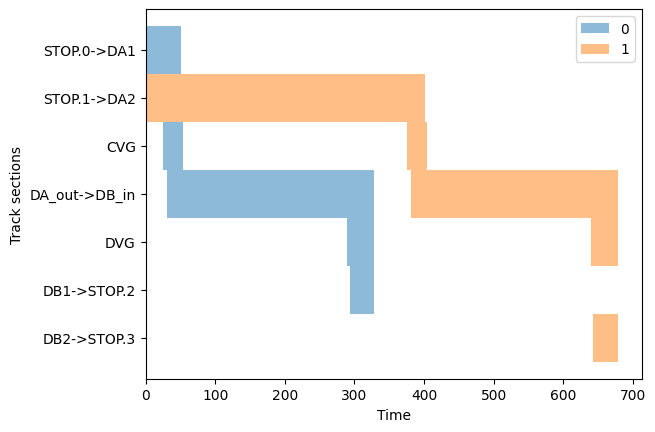

In [29]:
s.plot()

In [30]:
env = RegulEnv(s, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

In [31]:
from collections import deque
import random

from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import mask_to_index

In [32]:
def data_from_env(env: RegulEnv) -> Data:
    G = env.schedule.graph
    if env.schedule.has_conflicts(env.delayed_train):
        i = list(G.nodes).index(env.schedule.first_conflict(env.delayed_train)[0])
    else:
        i = 0 # arbitrary, will not be accounted in the loss calculations
    G = nx.convert_node_labels_to_integers(G, label_attribute='name')
    data = from_networkx(G.reverse(), group_node_attrs=['times'])
    data.pos_conflict = index_to_mask(torch.tensor(i), size = data.num_nodes)
    data.x = data.x.float()
    
    return data

In [33]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(tuple(args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [34]:
memory = ReplayMemory(50)

In [35]:
sc = schedule_from_simulation(infra, res, simplify_route_names=True)
sc = sc.add_delay(1,'STOP.1->DA2', 350).sort()
env = RegulEnv(sc, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

for delay in tqdm(np.random.default_rng().uniform(0, 700, 50)):
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')

    done = ~env.schedule.has_conflicts(env.delayed_train)
    while not done:
        # print(delay, env.schedule.first_conflict(env.delayed_train))
        s = data_from_env(env)
        a = env.action_space.sample()
        obs, reward, done, _ = env.step(a)
        sprime = data_from_env(env)
        memory.push(
            s,
            torch.tensor([a]),
            sprime,
            torch.tensor([reward], dtype=float),
            torch.tensor([done], dtype=torch.long)
        )

        

100%|██████████| 50/50 [00:59<00:00,  1.19s/it]


In [36]:
batch = memory.sample(25)
states_, actions_, next_states_, rewards_, done_= list(zip(*batch))

actions = torch.stack(actions_)
rewards = torch.stack(rewards_)
dones = torch.stack(done_)
states = DataLoader(states_, batch_size=len(states_))
next_states = DataLoader(next_states_, batch_size=len(next_states_))

In [37]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

NUM_NODE_FEATURES = 4

class DQGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(NUM_NODE_FEATURES, 16)
        self.conv2 = GCNConv(16, 8)
        self.linear = Linear(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)

        return x

In [38]:
from torch.nn import SmoothL1Loss, MSELoss

In [39]:
delays= list(range(60,640,20))

In [40]:
test_states = []
for delay in tqdm(delays):
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    test_states.append(data_from_env(env))

100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


In [41]:
import matplotlib.pyplot as plt
from IPython import display

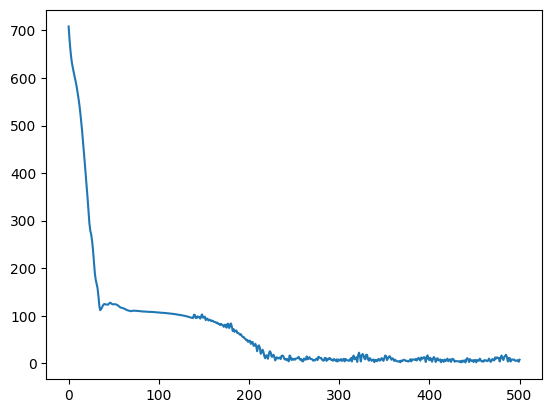

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
online_net = DQGCN().to(device)
target_net = DQGCN().to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.Adam(online_net.parameters(), lr=1e-2)
loss_func = SmoothL1Loss()


online_net.train()
losses = []
# for epoch in tqdm(range(1001)):
for epoch in range(501):
    
    # sample from replay buffer
    batch = memory.sample(len(memory))
    states_, actions_, next_states_, rewards_, done_= list(zip(*batch))

    actions = torch.stack(actions_)
    rewards = torch.stack(rewards_)
    dones = torch.stack(done_)
    states = DataLoader(states_, batch_size=len(states_))
    next_states = DataLoader(next_states_, batch_size=len(next_states_))
    batch_states = [batch for batch in states][0]
    batch_next_states = [batch for batch in next_states][0]

    out = online_net(batch_states)[batch_states.pos_conflict].gather(1, actions)
    target = (
        rewards +
        0.9 * target_net(batch_next_states)[batch_next_states.pos_conflict].max(1)[0]
        .unsqueeze(1)
        * (1 - done)
    )
    loss = loss_func(out, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())
    if epoch % 20 == 0:
        target_net.load_state_dict(online_net.state_dict())
        plt.figure(1)
        plt.clf()
        plt.plot(losses)
        plt.pause(0.001)
        display.clear_output(wait=True)

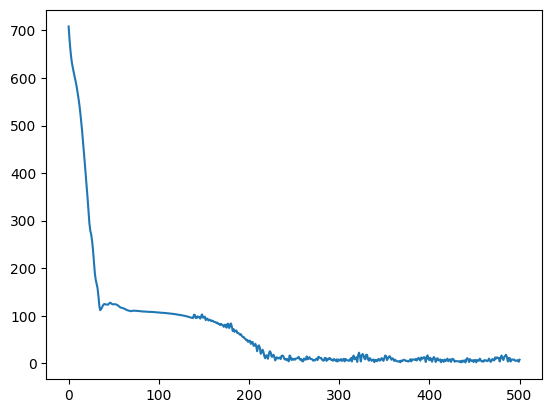

In [43]:
plt.plot(losses)

In [44]:
batch_test = [batch for batch in DataLoader(test_states, batch_size=len(test_states))][0]
res = online_net(batch_test)[batch_test.pos_conflict]
x = res.gather(1, torch.tensor([[0] for _ in range(len(res))])).squeeze().detach()
y = res.gather(1, torch.tensor([[1] for _ in range(len(res))])).squeeze().detach()

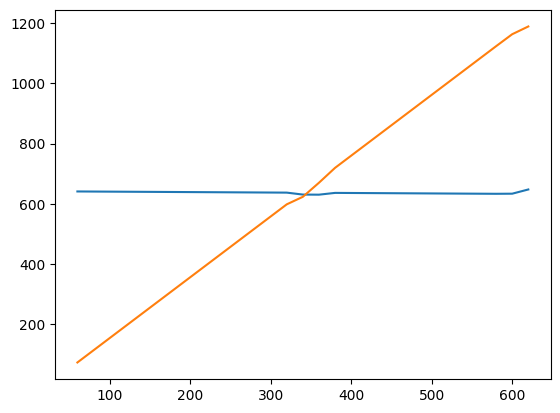

In [45]:

plt.plot(delays,-x,delays,-y)

## Brute force

In [46]:
import numpy as np

total_delay_0 = []
total_delay_1 = []

for delay in tqdm(delays):
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(0)
    except:
        reward = np.nan
    total_delay_0.append(-reward)
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(1)
    except:
        reward = np.nan
    total_delay_1.append(-reward)

100%|██████████| 29/29 [01:46<00:00,  3.69s/it]


Text(0, 0.5, '$Q(s,a)$ = Total delay at stations')

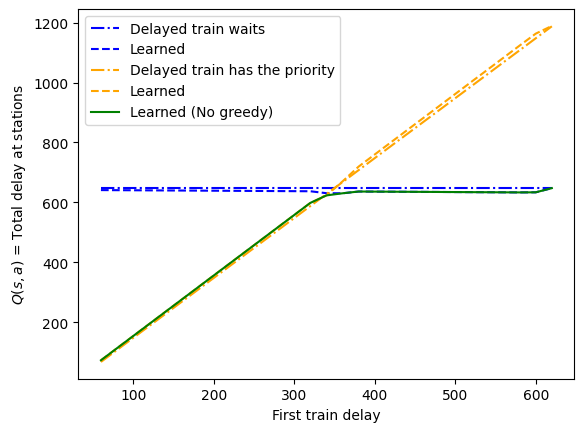

In [47]:
plt.plot(delays, total_delay_0, '-.', label='Delayed train waits', color='blue')
plt.plot(delays,-x, '--', color='blue', label='Learned')
plt.plot(delays, total_delay_1,  '-.', label='Delayed train has the priority', color='orange')
plt.plot(delays,-y, '--', color='orange', label='Learned')
plt.plot(delays, np.minimum(-x, -y), 'g-', label='Learned (No greedy)')
plt.legend()
plt.xlabel('First train delay')
plt.ylabel('$Q(s,a)$ = Total delay at stations')

In [49]:
env.schedule.df

0                  1          
                     s        e         s         e
STOP.0->DA1        0.0  670.829       NaN       NaN
STOP.1->DA2        NaN      NaN       0.0    968.39
CVG            644.993  674.183   942.554   971.744
DA_out->DB_in  651.034  948.595   948.595  1246.156
DVG            909.464  948.595  1207.025  1246.156
DB1->STOP.2    913.105  948.595       NaN       NaN
DB2->STOP.3        NaN      NaN  1210.666  1246.156